# New splitting of lesions

In [1]:
import json
import os
import numpy as np
from nibabel import load as load_nii
import nibabel as nib
from scipy import ndimage
from scipy.ndimage.morphology import generate_binary_structure as gbs
from scipy.ndimage.measurements import label
import matplotlib.pyplot as plt
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from scipy.ndimage.morphology import binary_dilation as bd
from scipy.ndimage.morphology import binary_opening as bo
from scipy.ndimage.morphology import binary_closing as bc
from scipy.ndimage.morphology import binary_fill_holes as bfh
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
%matplotlib inline
import sys
sys.path.append("..")
from config import *
from utils import generate_BIDS_path, get_dataframe_from_metadata, normalize_patch, load_lesions, get_dataframe_from_split_lesions

from confluent_split import load_patient_split_lesions
from munkres import Munkres
import cv2
import pandas as pd
import multiprocessing as mp

Loading configuration...
Configuration loaded successfully!
_____________________________



In [2]:
'''
Reference paper: http://www.ajnr.org/content/early/2018/02/22/ajnr.A5556
'''

'\nReference paper: http://www.ajnr.org/content/early/2018/02/22/ajnr.A5556\n'

In [3]:
SEGM_TH = 0.3
MIN_VOLUME = 14
MAX_DIMENSIONS = 22
REMOVE_SMALL = True
PERCENTAGE_CLUSTER = 0.8
MIN_PERCENTAGE_FOR_RIM_POS_PATCHES = 100

VERSION = "v05"

In [4]:
def create_folder_for_split_lesions(dataset_id, pat, der_folder, pipeline, session=1):
    # we create folder if it does not exist
    der_path = os.path.join(AVAILABLE_DATASETS_ROOTS[dataset_id], "derivatives", der_folder)
    if not os.path.exists(der_path):
        try:
            os.makedirs(der_path)
            print(f"[INFO] Derivatives folder for '{der_folder}' successfully created.")
        except: # Sometimes in multiprocessing this check is true for several processes and crashes
            pass
        
    # we create the description of the derivatives if it does not exist
    dataset_description_path = os.path.join(der_path, "dataset_description.json")
    if not os.path.exists(os.path.join(dataset_description_path)):
        descriptor = {
            "Name": der_folder,
            "BIDSVersion": BIDS_VERSION,
            "PipelineDescription": {
                "Name": pipeline,
                "version": VERSION,
                "segmentation_threshold": SEGM_TH,
                "min_volume": MIN_VOLUME,
                "max_dimensions": MAX_DIMENSIONS,
                "remove_small": REMOVE_SMALL,
                "corrector_after_hessian": PERCENTAGE_CLUSTER if REMOVE_SMALL else None,
                "min_percentage_for_rim_pos_patches": MIN_PERCENTAGE_FOR_RIM_POS_PATCHES,
                "clustering_algorithm": "Agglomerative",
            }
        }
        with open(dataset_description_path, "w") as outfile:
            json.dump(descriptor, outfile)
        print(f"[INFO] Description file for '{der_folder}' successfully created.")
    
    # we create the path for the generated file
    folder = os.path.join(der_path, f"sub-{pat:03d}", f"ses-{session:02d}")
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    return folder
    

def retrieve_centers_of_lesions(dataset_id, pat):
    folder_name, pipeline = SPLIT_LESIONS_METADATA[VERSION]["folder_name"], SPLIT_LESIONS_METADATA[VERSION]["pipeline"]
    where_to_save = create_folder_for_split_lesions(dataset_id, pat, folder_name, pipeline)
    
    # Loading of paths.
    dataset = AVAILABLE_DATASETS[dataset_id]
    if len(dataset.get(return_type="filename", subject=f"{pat:03d}", **CONTRASTS["PMAP"])) == 0:
        print(f"Patient {dataset_id}.{pat} skipped due to absence of Probability Map.")
        return -1
    
    prob_map_path = dataset.get(return_type="filename", subject=f"{pat:03d}", **CONTRASTS["PMAP"])[0]
    split_lesions_path = generate_BIDS_path(dataset_id, subject=f"{pat:03d}", scope=SPLIT_LESIONS_METADATA[VERSION]["pipeline"], suffix=SPLIT_LESIONS_METADATA[VERSION]["suffix"], acquisition=None, extension="nii.gz")
    
    if os.path.exists(split_lesions_path):
        print(f"Patient {dataset_id}.{pat} skipped because lesions for version {VERSION} are already created.")
        return -1

    # LOAD PROBABILITY MAP
    m_image = nib.load(prob_map_path)
    o, h = m_image.affine, m_image.header
    prob_map = np.squeeze(m_image.get_fdata())
    
    # We create the lesions mask thresholding the probabilities.
    lesions_mask = np.zeros_like(prob_map)
    lesions_mask[normalize_patch(prob_map, "local_max_01") > SEGM_TH] = 1
    _, n_labels_original = ndimage.label(lesions_mask)

    # SPLIT OF LESIONS
    
    # we smooth the probability map first
    prob_map = cv2.blur(prob_map, (5,5))
    prob_map = ndimage.rotate(prob_map, 90, axes=(0,2), reshape=True, order=0, mode='nearest')
    prob_map = cv2.blur(prob_map, (5,5))
    prob_map = ndimage.rotate(prob_map, -90, axes=(0,2), reshape=True, order=0, mode='nearest')
    prob_map = normalize_patch(prob_map, "local_max")
    nifti_out = nib.Nifti1Image(prob_map, affine = o, header = h)
    nifti_out.to_filename(split_lesions_path.replace(".nii.gz", "probblurred.nii.gz"))
    #nifti_out = nib.Nifti1Image(lesions_mask, affine = o, header = h)
    #nifti_out.to_filename(split_lesions_path.replace(".nii.gz", "lesions.nii.gz"))
    
    # We will focus only on the thresholded lesions.
    prob_map[lesions_mask == 0] = 0
    
    # We compute the hessian matrix and its eigenvalues for all the image
    H_elems = hessian_matrix(prob_map, sigma=1.0, order='rc')
    eigen = hessian_matrix_eigvals(H_elems)  # Here the sigma can be changed..
    
    # We discard all voxels with at least one positive eigenvalue
    split_lesions = np.copy(lesions_mask)
    split_lesions[np.where(eigen[0] > 0) or np.where(eigen[1] > 0) or np.where(eigen[2] > 0)] = 0
    
    
    # 1. If the larger dimension of the lesion in the automatic segmentation is smaller than MAX_DIMENSIONS => keep it as it is
    # 2. If it is bigger than that, we use the lesion automatic split.
    lesions_mask_labels, _ = ndimage.label(lesions_mask)
    lesions_mask = np.zeros_like(lesions_mask)
    counter = 1
    for l in np.unique(lesions_mask_labels)[1:]:
        current_lesion_mask = (lesions_mask_labels == l)
        objects = ndimage.find_objects(current_lesion_mask)
        if len(objects) > 1:
            raise("PROBLEM!")
        x, y, z = objects[0]
        vol = np.sum(current_lesion_mask)
        max_dim = max(x.stop - x.start, y.stop - y.start, z.stop - z.start)
        # We filter the candidates by size and store those > MIN_VOLUME. 14 is the recommended WM min lesion size
        if max_dim <= MAX_DIMENSIONS and vol > MIN_VOLUME:
            # We keep the lesion as it is
            lesions_mask[current_lesion_mask] = counter
            counter += 1
        elif vol > MIN_VOLUME:
            # HERE WE SPLIT THE CONFLUENT LESION: hessian + clustering
            split_lesion = np.zeros_like(lesions_mask)
            split_lesion[(current_lesion_mask) & (split_lesions == 1)] = 1

            # We first remove the small connected components of the split lesion if flag activated
            if REMOVE_SMALL:
                labels, _ = ndimage.label(split_lesion)
                for lab in np.unique(labels)[1:]:
                    current_lesion_mask = (labels == lab)
                    if np.sum(current_lesion_mask) <= PERCENTAGE_CLUSTER * MIN_VOLUME:
                        # assign voxels to output
                        split_lesion[current_lesion_mask] = 0
            
            # If the split result is only 1 lesion => keep it as a whole
            lesions, num_les = ndimage.label(split_lesion)
            if num_les <= 1:
                lesions_mask[(current_lesion_mask) & (split_lesions == 1)] = counter
                counter += 1
                continue
                
            # We will cluster them in function of their center of mass
            labels = range(1, num_les + 1)
            centers = ndimage.measurements.center_of_mass(split_lesion, lesions, labels)
            
            # We find the best number of clusters, with the limit set in the number of lesions itself (each connected component will be a lesion)
            finish = False
            n_clusters = 1
            while not finish and n_clusters < num_les:
                clusters = np.copy(split_lesion)
                model = AgglomerativeClustering(n_clusters = n_clusters)
                classes = model.fit_predict(centers)
                classes_dict = {}
                # we set the new labels and we create a dictionary that matches the new label with the previous ones
                for (lab, cl) in zip(labels, classes):
                    clusters[lesions == lab] = cl + 1
                    if cl+1 not in classes_dict:
                        classes_dict[cl+1] = [lab, ]
                    else:
                        classes_dict[cl+1].append(lab)

                finish = True
                for cl in classes_dict:
                    if len(classes_dict[cl]) == 1:
                        continue # we do not count it, since we can not split it more (it corresponds to 1 split lesion, not clusterized)
                    objects = ndimage.find_objects((clusters == cl).astype(int))
                    assert len(objects) == 1
                    obj = objects[0]
                    if obj is None:
                        print("ERROR: This should not happen!")
                        continue
                    x, y, z = obj
                    # we extract the bounding box that includes all clusterized lesions
                    max_dim = max(x.stop - x.start, y.stop - y.start, z.stop - z.start)
                    finish = finish and (max_dim <= np.ceil(PERCENTAGE_CLUSTER * MAX_DIMENSIONS)) # all of them have to fit inside a patch of that size
                    
                n_clusters += 1
                
            if not finish:
                # we did not do any clustering => we consider all lesions
                lesions[lesions != 0] += counter
                lesions_mask += lesions
                counter += num_les
            else:
                # we update the final mask with the clusters of lesions
                for i in range(1, n_clusters):
                    lesions_mask[clusters == i] = counter
                    counter += 1
            
        
    # SAVE RESULTS
    #print(f"{dataset_id}.{pat} - TOTAL: {n_labels_original} -> {counter-1} lesions.")
    
    nifti_out = nib.Nifti1Image(lesions_mask, affine = o, header = h)
    nifti_out.to_filename(split_lesions_path)
    
    return dataset_id, pat, n_labels_original, counter-1


def retrieve_all_patients_centers(cpus = 6):
    pool = mp.Pool(min(cpus, mp.cpu_count()))
    processes = []
    results = []
    for dataset_id in range(len(AVAILABLE_DATASETS)):
        dataset = AVAILABLE_DATASETS[dataset_id]
        for pat in dataset.get_subjects():
            def callback(result):
                if result is None:
                    print("ERROR!")
                    return
                elif result == -1:
                    return
                d_id, pat, bef, after = result
                print(f"{d_id}.{pat} - TOTAL: {bef} -> {after} lesions.")
                results.append(result)
            processes.append(pool.apply_async(retrieve_centers_of_lesions, args=(dataset_id, int(pat)), callback=callback))

    for p in processes:
        p.get()
    pool.close()
    pool.join()

In [5]:
def match_split_lesions_with_GT(dataset_id, pat):
    np.random.seed(seed=0)
    
    #m = Munkres()
    
    folder_name, pipeline = SPLIT_LESIONS_METADATA[VERSION]["folder_name"], SPLIT_LESIONS_METADATA[VERSION]["pipeline"]
    
    # Loading of paths.
    dataset = AVAILABLE_DATASETS[dataset_id]
    split_lesions_path = generate_BIDS_path(dataset_id, subject=f"{pat:03d}", scope=SPLIT_LESIONS_METADATA[VERSION]["pipeline"], suffix=SPLIT_LESIONS_METADATA[VERSION]["suffix"], acquisition=None, extension="nii.gz")
    rimpos_annotations_paths = dataset.get(return_type="filename", subject=f"{pat:03d}", **CONTRASTS["EXPERTS_ANNOTATIONS"])
    meta_split_lesions_path = generate_BIDS_path(dataset_id, subject=f"{pat:03d}", scope=SPLIT_LESIONS_METADATA[VERSION]["pipeline"], suffix=SPLIT_LESIONS_METADATA[VERSION]["suffix"], acquisition=None, extension="csv")
    
    if not os.path.exists(split_lesions_path):
        print(f"Patient {dataset_id}.{pat} skipped because split lesions for version {VERSION} are missing.")
        return
    if os.path.exists(meta_split_lesions_path):
        print(f"Patient {dataset_id}.{pat} skipped because metadata of split lesions for version {VERSION} already exists.")
        return
    
    # IF there are annotations of rim+, we match them with the lesions.
    rimpos_centers = []
    split_lesions_centers = []
    
    
    # we retrieve them and make the association with split lesions
    m_image = nib.load(split_lesions_path)
    split_lesions = m_image.get_fdata()
    if len(rimpos_annotations_paths) > 0:
        gt_lesions = nib.load(rimpos_annotations_paths[0]).get_fdata()
    else:
        gt_lesions = np.zeros_like(split_lesions)
    o, h = m_image.affine, m_image.header

    labels_GT = np.unique(gt_lesions)
    labels_GT = np.delete(labels_GT, np.argwhere(labels_GT == 0))
    n_labels_GT = len(labels_GT)

    # quick check that everything is okay
    #assert n_labels_GT == len(df_lesions[(df_lesions["rim"]) & (df_lesions["dataset"] == dataset_id) & (df_lesions["patient"] == pat)])
    for lab in labels_GT:
        rimpos_centers.append([int(el) for el in ndimage.measurements.center_of_mass(gt_lesions == lab)])

    print(f"{dataset_id} - {pat} - {len(rimpos_centers)} rim+ lesion centers extracted.")

    labels_split = np.unique(split_lesions)
    labels_split = np.delete(labels_split, np.argwhere(labels_split == 0))
    n_labels_split = len(labels_split)
    for lab in labels_split:
        split_lesions_centers.append([int(el) for el in ndimage.measurements.center_of_mass(split_lesions == lab)])

    matrix_distances = np.zeros((len(rimpos_centers), len(split_lesions_centers)))
    matrix_intersection = np.zeros((len(rimpos_centers), len(split_lesions_centers)))
    matrix_intersection_perc = np.zeros((len(rimpos_centers), len(split_lesions_centers)))
    for i in range(len(rimpos_centers)):
        for j in range(len(split_lesions_centers)):
            label_GT, label_lesions = i+1, j+1
            # save the distance between them
            c1, c2 = rimpos_centers[i], split_lesions_centers[j]
            dist = np.linalg.norm(np.array(c1) - np.array(c2))
            matrix_distances[i,j] = dist
            # check for intersection
            if dist < 15: # to optimize
                current_les = (split_lesions == label_lesions).astype(int)
                current_rim_slice = (gt_lesions == label_GT).astype(int)
                matrix_intersection[i,j] = np.sum(current_les * current_rim_slice)
            else:
                matrix_intersection[i,j] = 0
                matrix_intersection_perc[i,j] = 0

    pos_patches = np.zeros_like(gt_lesions)
    result = np.zeros_like(gt_lesions)
    counter_rim = 1
    counter_non_rim = 1
    result_data = []
    MAX_REAL = len(split_lesions_centers)
    i = 0
    while i < len(split_lesions_centers):
        c = split_lesions_centers[i]
        # we build the bounding box and get the percentage of rim+ slice inside
        a = int(28/2) # PATCH SIZE = 28x28x28
        patch = gt_lesions[max(0, c[0]-a):min(c[0]+a, gt_lesions.shape[0]), 
                           max(0, c[1]-a):min(c[1]+a, gt_lesions.shape[1]), 
                           max(0, c[2]-a):min(c[2]+a, gt_lesions.shape[2])]
        perc_volume_rims_included_in_the_patch = [np.sum(patch == lab) / np.sum(gt_lesions == lab) for lab in np.unique(patch)[1:]]
        voxels_rims_included_in_the_patch = [np.sum(patch == lab) for lab in np.unique(patch)[1:]]

        maximum = 0 if len(perc_volume_rims_included_in_the_patch) == 0 else max(perc_volume_rims_included_in_the_patch)

        # FULL OF HYPERPARAMETERS:
        #     0.8 => we only want to augment those rim+ well fit inside the patch, so we can find patches around it that they still contain it.
        #     2 + np.random.rand() * 8 => distance to which generate the augmented patches.
        if maximum >= 0.8 and i < MAX_REAL:
            # DA
            for x in (-1, 1):
                for y in (-1, 1):
                    for z in (-1, 1):
                        if np.random.rand() > 0.40:
                            split_lesions_centers.append((c[0] + x * int(np.ceil(2 + np.random.rand() * 8)), 
                                                          c[1] + y * int(np.ceil(2 + np.random.rand() * 8)), 
                                                          c[2] + z * int(np.ceil(2 + np.random.rand() * 8))))

        b = 2
        if maximum >= MIN_PERCENTAGE_FOR_RIM_POS_PATCHES / 100: # RIM+
            result_data.append((dataset_id, pat, 1000 + counter_rim, c[0], c[1], c[2], perc_volume_rims_included_in_the_patch, voxels_rims_included_in_the_patch, i < MAX_REAL))

            # for checking visually all lesions
            result[c[0]-b:c[0]+b, c[1]-b:c[1]+b, c[2]-b:c[2]+b] = 1000 + counter_rim

            # for checking visually the rim+ patches
            pos_patches[max(0, c[0]-a):min(c[0]+a, gt_lesions.shape[0]), 
                       max(0, c[1]-a):min(c[1]+a, gt_lesions.shape[1]), 
                       max(0, c[2]-a):min(c[2]+a, gt_lesions.shape[2])] = counter_rim
            a -= 1
            pos_patches[max(0, c[0]-a):min(c[0]+a, gt_lesions.shape[0]), 
                       max(0, c[1]-a):min(c[1]+a, gt_lesions.shape[1]), 
                       max(0, c[2]-a):min(c[2]+a, gt_lesions.shape[2])] = 0

            counter_rim += 1
        elif i < MAX_REAL: # RIM- => we do not risk to create rim- patches close to rim+ ones
            result_data.append((dataset_id, pat, 2000 + counter_non_rim, c[0], c[1], c[2], perc_volume_rims_included_in_the_patch, voxels_rims_included_in_the_patch, i < MAX_REAL))
            # for checking visually all lesions
            result[c[0]-b:c[0]+b, c[1]-b:c[1]+b, c[2]-b:c[2]+b] = 2000 + counter_rim
            counter_non_rim += 1
        i += 1

    nifti_out = nib.Nifti1Image(pos_patches, affine = o, header = h)
    nifti_out.to_filename(split_lesions_path.replace(".nii.gz", "_rimpos.nii.gz"))
    nifti_out = nib.Nifti1Image(result, affine = o, header = h)
    nifti_out.to_filename(split_lesions_path.replace(".nii.gz", "_result.nii.gz"))

    df = pd.DataFrame(result_data, columns=["dataset_id", "patient", "lesion", "x", "y", "z", "percentage_rims", "voxels_rims", "real"])
    df.to_csv(meta_split_lesions_path, index=False)
    return df


def match_all_patients_with_GT(cpus=6):
    data = []
    pool = mp.Pool(min(cpus, mp.cpu_count()))
    processes = []
    results = []
    for dataset_id in range(len(AVAILABLE_DATASETS)):
        dataset = AVAILABLE_DATASETS[dataset_id]
        for pat in dataset.get_subjects():
            def callback(result):
                if result is None:
                    #print(result)
                    return
                data.append(result)
            processes.append(pool.apply_async(match_split_lesions_with_GT, args=(dataset_id, int(pat)), callback=callback))

    for p in processes:
        p.get()
    pool.close()
    pool.join()

In [9]:
cpus = 8

#retrieve_all_patients_centers(cpus=cpus)
match_all_patients_with_GT(cpus=cpus)

0 - 63 - 0 rim+ lesion centers extracted.
0 - 59 - 0 rim+ lesion centers extracted.
0 - 61 - 0 rim+ lesion centers extracted.0 - 56 - 0 rim+ lesion centers extracted.

0 - 62 - 0 rim+ lesion centers extracted.
0 - 58 - 1 rim+ lesion centers extracted.
0 - 60 - 1 rim+ lesion centers extracted.
0 - 57 - 3 rim+ lesion centers extracted.
0 - 65 - 3 rim+ lesion centers extracted.
0 - 66 - 4 rim+ lesion centers extracted.
0 - 64 - 11 rim+ lesion centers extracted.
0 - 67 - 2 rim+ lesion centers extracted.
0 - 68 - 0 rim+ lesion centers extracted.
0 - 69 - 1 rim+ lesion centers extracted.
0 - 70 - 6 rim+ lesion centers extracted.
0 - 71 - 0 rim+ lesion centers extracted.
0 - 72 - 3 rim+ lesion centers extracted.
0 - 73 - 0 rim+ lesion centers extracted.
0 - 74 - 9 rim+ lesion centers extracted.
0 - 76 - 0 rim+ lesion centers extracted.
0 - 75 - 5 rim+ lesion centers extracted.
0 - 77 - 2 rim+ lesion centers extracted.
0 - 78 - 8 rim+ lesion centers extracted.
0 - 79 - 1 rim+ lesion centers ex

ValueError: operands could not be broadcast together with shapes (256,336,384) (256,360,384) 

0 - 100 - 0 rim+ lesion centers extracted.
0 - 103 - 0 rim+ lesion centers extracted.
0 - 102 - 6 rim+ lesion centers extracted.
0 - 101 - 12 rim+ lesion centers extracted.
0 - 104 - 0 rim+ lesion centers extracted.
0 - 105 - 0 rim+ lesion centers extracted.
0 - 106 - 0 rim+ lesion centers extracted.
0 - 107 - 0 rim+ lesion centers extracted.
0 - 110 - 0 rim+ lesion centers extracted.
0 - 108 - 14 rim+ lesion centers extracted.
0 - 109 - 12 rim+ lesion centers extracted.
0 - 113 - 2 rim+ lesion centers extracted.
0 - 112 - 6 rim+ lesion centers extracted.
0 - 114 - 8 rim+ lesion centers extracted.
0 - 115 - 5 rim+ lesion centers extracted.
0 - 116 - 1 rim+ lesion centers extracted.
0 - 117 - 1 rim+ lesion centers extracted.
0 - 118 - 6 rim+ lesion centers extracted.
0 - 120 - 0 rim+ lesion centers extracted.
0 - 121 - 0 rim+ lesion centers extracted.
0 - 122 - 1 rim+ lesion centers extracted.
0 - 123 - 4 rim+ lesion centers extracted.
0 - 125 - 4 rim+ lesion centers extracted.
0 - 124 

In [7]:
df = get_dataframe_from_split_lesions(VERSION)

In [8]:
print(len(df[(df["real"]) & (df["lesion"] // 2000 == 1)].index))
print(len(df[(df["real"]) & (df["lesion"] // 1000 == 1)].index))
print(len(df["patient"].unique()))

3232
300
68


In [9]:
print(len(df[(df["lesion"] // 2000 == 1)].index))
print(len(df[(df["lesion"] // 1000 == 1)].index))
print(len(df["patient"].unique()))

3232
1228
68


In [10]:
df[(df["lesion"] // 1000 == 1)]

,dataset_id,patient,lesion,x,y,z,percentage_rims,voxels_rims,real
1,0,57,1001,88,252,237,[1.0],[655],True
3,0,57,1002,99,221,259,[1.0],[298],True
4,0,57,1003,100,125,279,[1.0],[1206],True
12,0,57,1004,80,245,230,[0.9603053435114504],[629],False
13,0,57,1005,80,246,247,[0.9282442748091603],[608],False
...,...,...,...,...,...,...,...,...,...
79,0,112,1029,148,192,287,"[1.0, 0.875]","[44, 28]",False
80,0,112,1030,160,177,293,"[1.0, 1.0]","[57, 44]",False
81,0,112,1031,159,175,305,"[0.8070175438596491, 1.0]","[46, 44]",False
82,0,112,1032,159,194,304,"[1.0, 1.0]","[57, 44]",False


In [ ]:
df_lesions = get_dataframe_from_metadata()
df_lesions

print(len(df_lesions[(df_lesions["patient"].isin(df["patient"].unique())) & (df_lesions["lesion"] // 2000 == 1)].index))
print(len(df_lesions[(df_lesions["patient"].isin(df["patient"].unique())) & (df_lesions["lesion"] // 1000 == 1)].index))

In [ ]:
df

# EXTRACT LESIONS WITH n ELASTIC DEFORMATIONS EACH
Tested = True

In [6]:
%%time

lpp = load_lesions(PATCH_SIZE, from_segmentation=True, deformed=1, only_real=False, debug=True, split_version="v02")
lpp_orig = load_lesions(PATCH_SIZE, from_segmentation=True, deformed=None, only_real=False, debug=True, split_version="v02")

[START] Loading lesions (deformed=None, asyncr=True, cpus=8, segm=True)...
[ERROR] Patients not loaded successfully: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 84, 85, 103, 107, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
[END] Lesions loaded successfully!
[INFO] It took 1.47 minutes to load the data.


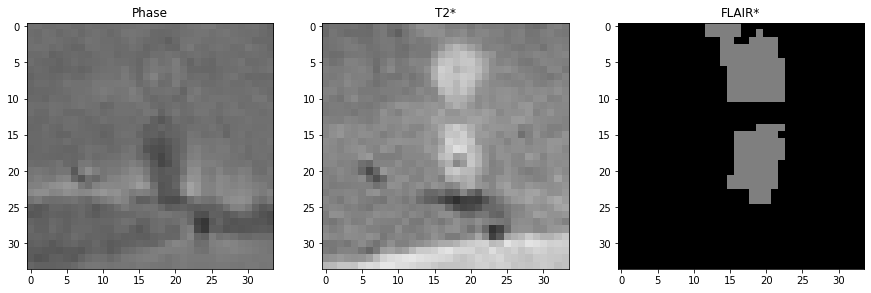

In [11]:
from widgets import ContrastsViewer3D
lesion = lpp[0][93]["1004"]
ContrastsViewer3D(lesion["T2STAR_PHASE"], lesion["T2STAR_MAG"], lesion["MASK"], titles=("Phase", f"T2*", "FLAIR*"), figsize=(15, 15))

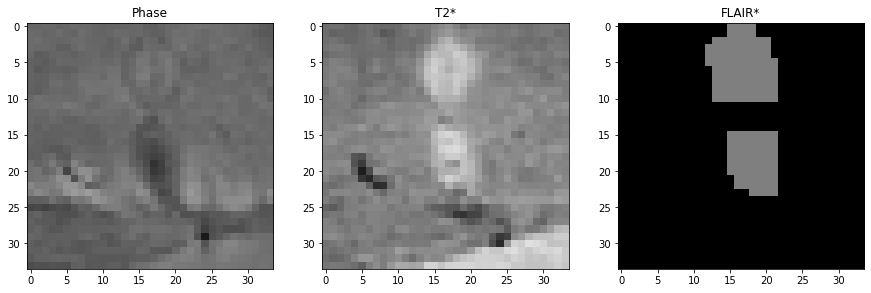

In [10]:
from widgets import ContrastsViewer3D
lesion = lpp_orig[0][93]["1004"]
ContrastsViewer3D(lesion["T2STAR_PHASE"], lesion["T2STAR_MAG"], lesion["MASK"], titles=("Phase", f"T2*", "FLAIR*"), figsize=(15, 15))

In [ ]:
print("HOla")

In [13]:
prova = ('056', '057', '058', '059', '060', '061', '062', '063', '064', '072', '073', '075', '076', '077', '078', '079', '080', '081', '082', '092', '094', '095', '096', '097', '098', '099', '100', '101', '102', '104', '105') + ('071', '083', '106', '108', '109', '112', '110') + ('065', '066', '067', '068', '069', '070', '074', '093')

print(list(sorted(prova)))

['056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '104', '105', '106', '108', '109', '110', '112']
